# Convolution Neural Network (CNN)

L'objectif de ce notebook est de présenter un CNN, son utilisation et son développement

Le CNN est une architecture de Réseau de Neurone qui permet de classifier des Images.

L'[Architecture d'un CNN](Images\Architecture_CNN.png) est constituée de plusieurs couches succesives. Deux familles de couches sont trouvables, dans un CNN, qui sont :
- Convolution qui agit comme un filtre sur les données qui parcours sur un ensemble de la sous image. L'opération réalisée est une étape de convolution sur l'image.
- Pooling qui permet d'extraire les informations et de l'enregistrer. Cette étape permet également de rendre le Réseaux moins sensible au sur-apprentissage. L'opération réalisée sur le sous-ensemble est une méthode d'aggrégation (sum, mean, max, min par exemple).

### Développement du CNN 
Ce Projet a pour objectif de classifier des images provenant du jeu de données CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Configuration Global

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

### Importe toutes les données

In [4]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Visualisation des données

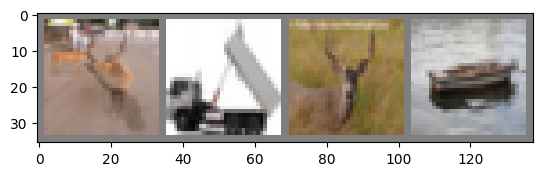

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


### Création du Réseau de Neurone

Les dimension de l'output de la convolution layer est définie comme suit :

$\frac{W - F + 2P}{S} + 1$ avec 

W : La taille de l'arret de l'image = 5;
F : La taille de l'arret du filtre = 3;
P : Le Padding choisit = 0;
stride : Le pas = 1;

Le format de l'output du layer de convolution dans ce cas vaut 3 x 3.

En ce qui concerne les inputs : 3 input pour les cannaux de l'images (RGB), 6 output pour les cannaux de sortie, 5 pour la taille du kernel

In [18]:
conv1 = nn.Conv2d(3, 6, 6) #dimension 3 = cannaux de couleur x output x Taille Kernel
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

conv1(images).shape

torch.Size([4, 6, 27, 27])

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #dimension 3 = cannaux de couleur x output x Taille Kernel (nombre de pixel de côté qui sera considéré pour être filtré)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #Fully connected layer 16*5*5 = 400 size (information résultant de l'opération de tout mettre dans une colonne - Flatten)
        self.fc2 = nn.Linear(120, 84) #Fully connected layer
        self.fc3 = nn.Linear(84, 10) #Fully connected layer

    def forward(self, x):
        # -> n, 3, 32, 32
        # F.relu(self.conv1(x) -> n, 3, 28, 28 (32 - 5 + 1) [le 1 provient du fait que les coins de l'images ne sont pas prise en compte]
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14 | Pool permet de réduire la taille de la matrice par 2
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400 # Opération de Flatten
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10 | Pas de fonction d'activation car elle est déjà présent dans la fonction de loss!
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Entrainement du Réseau de Neurone

In [7]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.3061
Epoch [1/5], Step [4000/12500], Loss: 2.2715
Epoch [1/5], Step [6000/12500], Loss: 2.2857
Epoch [1/5], Step [8000/12500], Loss: 2.1516
Epoch [1/5], Step [10000/12500], Loss: 2.0651
Epoch [1/5], Step [12000/12500], Loss: 2.1359
Epoch [2/5], Step [2000/12500], Loss: 1.7244
Epoch [2/5], Step [4000/12500], Loss: 1.3644
Epoch [2/5], Step [6000/12500], Loss: 1.3421
Epoch [2/5], Step [8000/12500], Loss: 1.2035
Epoch [2/5], Step [10000/12500], Loss: 1.9047
Epoch [2/5], Step [12000/12500], Loss: 1.1929
Epoch [3/5], Step [2000/12500], Loss: 1.4088
Epoch [3/5], Step [4000/12500], Loss: 1.5618
Epoch [3/5], Step [6000/12500], Loss: 2.0569
Epoch [3/5], Step [8000/12500], Loss: 1.8352
Epoch [3/5], Step [10000/12500], Loss: 1.3004
Epoch [3/5], Step [12000/12500], Loss: 1.4616
Epoch [4/5], Step [2000/12500], Loss: 1.0701
Epoch [4/5], Step [4000/12500], Loss: 1.2050
Epoch [4/5], Step [6000/12500], Loss: 0.9296
Epoch [4/5], Step [8000/12500], Loss: 1.3637
Epoc

### Vérification de l'entrainement dans un cas de test

In [8]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 50.06 %
Accuracy of plane: 51.3 %
Accuracy of car: 73.3 %
Accuracy of bird: 41.9 %
Accuracy of cat: 30.3 %
Accuracy of deer: 25.9 %
Accuracy of dog: 42.1 %
Accuracy of frog: 73.8 %
Accuracy of horse: 58.6 %
Accuracy of ship: 65.0 %
Accuracy of truck: 38.4 %


### Transfert Learning

A faire